# Tarea 2 ML

Ignacio loayza 201273604-8  
Camilo Perez 201273533-5


## I ) Tipos de Fronteras de Clasificación
Iniciamos el estudio generando el dataset a utilizar y seteando la semilla.

In [2]:
#encoding:UTF-8

# Uno de nosotros usa python 2 y el otro python 3
from __future__ import print_function, unicode_literals

# SpeedML para graficos bonitos
from speedml import Speedml

# estadistica
import pandas as pd

#pyplot
import matplotlib.pyplot as plt
%matplotlib inline

# numpy
import numpy as np

#Utilizaremos la semilla = "Ñanculef es mi pastor, nada me ha de  faltar"
seed = "Ñanculef es mi pastor, nada me ha de faltar"
seed = hash(seed)%2^32

## Utils
from sklearn.utils import check_random_state
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score
from ipywidgets import interactive
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier
from ipywidgets import interactive
from sklearn.linear_model import LogisticRegression as LR

# Funciones utiles
"""
visualize_border puede hacer dos cosas, si no se le pasa un modelo permite
    visualizar la distirbución de los datos. Si se le pasa entrega el gráfico de
    distribucion de los datos junto con la frontera de clasificación del modelo.
"""
def visualize_border(x, y, title = "", model = None):
        fig = plt.figure(figsize=(12,6))
        plt.scatter(x[:,0], x[:,1], s = 50, c=y, cmap=plt.cm.winter)
        h = .02 #step size?
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max()+1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max()+1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        
        if model is not None:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, cmap = plt.cm.Paired)

        plt.title(title)
        plt.show()
        
"""
visualize_border_interactive grafica la frontera de decisión utilizando visualize_border,
adicionando la opción de ingresar un parámetro
"""
def visualize_border_interactive(param, learner, krnl):
    model = train_model(param, model = learner, kernel = krnl)
    visualize_border(X,y,model = model)
    y_pred = model.predict(X)
    y_true = y
    print("Miss classification error: %f"%(1-accuracy_score(y_true,y_pred)))

def train_model(param, model = "LR", pen = "l1", kernel = "linear"):
    if(model == "LR"):
        model = LR()
        model.set_params(C = param, penalty = pen)

    elif(model == "SVM"):
        model = SVM()
        model.set_params(C = param, kernel = kernel)
        
    model.fit(X,y)
    return model

/Users/Ignacio/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#Generamos el dataset a utilizar
n_samples = 500
mean = (0,-4)
C = np.array([[0.3,0.1],[0.1,1.5]])
datos1 = np.random.multivariate_normal(mean,C,n_samples)
outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
datos2 = np.vstack((outer_circ_x, outer_circ_y)).T

generator = check_random_state(seed)
datos2 += generator.normal(scale=0.3,size = datos2.shape)


> ### Análisis exploratorio de Datos

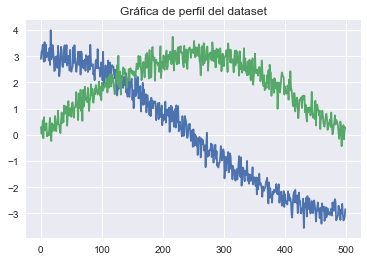

In [4]:
plt.plot(datos2)
plt.title("Gráfica de perfil del dataset")
plt.show()

> a) Construimos el dataset común con los dos conjuntos generados, posteriormente realizamos el shift de algunos valores de un conjunto al otro, con le fin de hacer menos trivial el ejercicio.

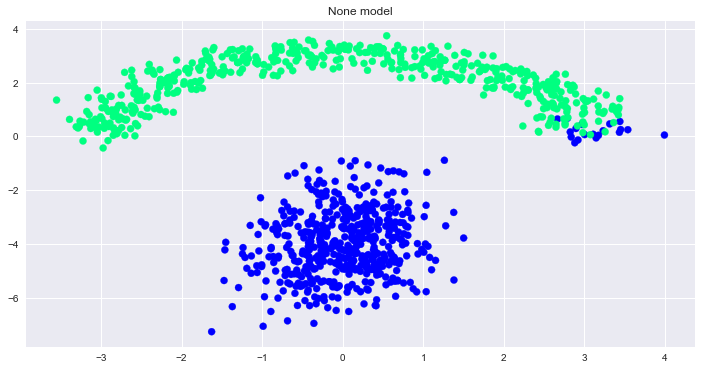

In [5]:
X = np.concatenate((datos1,datos2), axis = 0)
n = 20 #ruido?
y1 = np.zeros(datos1.shape[0]+n)
y2 = np.ones(datos2.shape[0]-n)
y = np.concatenate((y1,y2),axis = 0)
visualize_border(X,y,"None model")

> b) Entrenamos LDA y visualizamos la frontera de decisión:

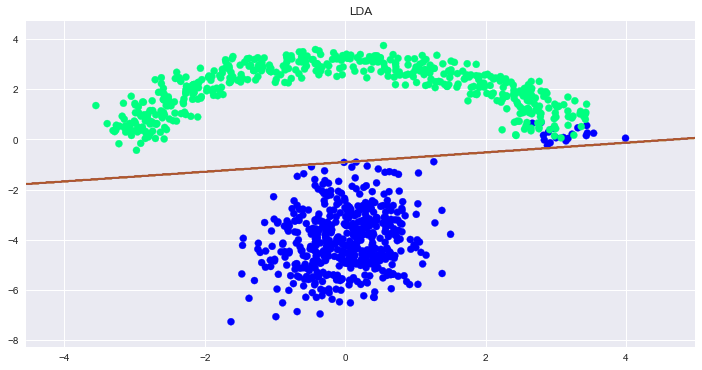

In [6]:
lda_model = LDA()
lda_model.fit(X,y)
visualize_border(X,y,title = "LDA",model = lda_model)

Observamos que LDA encuentra una frontera aceptable, teniendo en cuenta ciertos fallos de clasificación (cercanos al punto (0,-2)) que parecen ser inevitables debido a la naturaleza de los datos

> c) Entrenamos ahora utilizando QDA

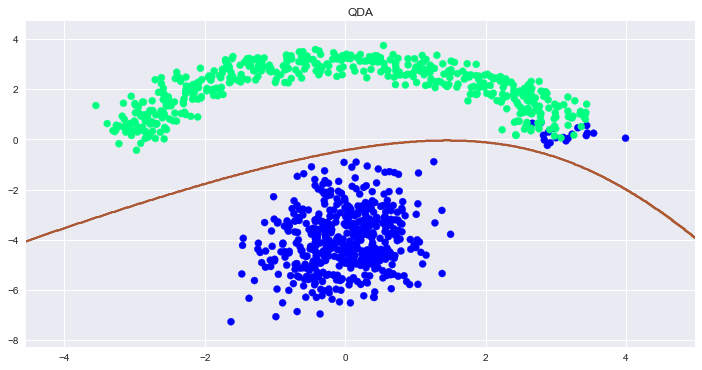

In [7]:
qda_model = QDA()
qda_model.fit(X,y)
visualize_border(X,y, title = "QDA", model = qda_model)

> c) La frontera que implementa QDA soluciona el error de clasificación que se presentaba en los puntos cercanos a (0,-2) en LDA, sin embargo, aún se hace presente el error de clasificación de los valores afectados por el ruido en el cuadrante (2:4,0:2).  
> Podemos explicar el rendimiento de QDA versus LDA recordando los discriminadores probabilísticos implementados en cada método:
>> * LDA para dos clases: Implementa un discriminador probabilístico condicional, asumiendo que las funciones de probabilidad marginal son distribuidas bajo una normal con media y covarianza $(\mu_0,\sum_0)$ y $(\mu_1,\sum_1)$ para las clases. La solución al problema de clasificación mediante LDA entonces, se basa en la evaluación de la función de verosimilitud y aplicando un umbral de decisión.
>> * QDA: Similar a LDA, este clasificador asume normalidad, sin embargo, QDA no asume que la covarianza de cada clase es igual (a diferencia de LDA). De igual forma que en LDA, en QDA la decisión de clasificación se basa en el análisis de la tasa de verosimilitud. En QDA se asume una solución cuadrática en las mediciones, es decir:
$$x^TAx + b^Tx + C$$

> d) Comparamos el rendimiento de QDA y LDA mediante el error de clasificación.

In [8]:
y_pred_qda = qda_model.predict(X)
y_true = y

y_pred_lda = lda_model.predict(X)

print("Miss Classification loss for QDA: %f"%(1-accuracy_score(y_true, y_pred_qda)))
print("Miss Classification loss for LDA: %f"%(1-accuracy_score(y_true, y_pred_lda)))

Miss Classification loss for QDA: 0.020000
Miss Classification loss for LDA: 0.020000


> LDA presenta mayor error que QDA, lo que se esperaba que sucediese, pues LDA no logra evitar el error de clasificación en el sector cercano a (0,-2) mencionado anteriormente, QDA si. Por otro lado el error de clasificación obtenido para QDA tiene sentido pues los datos incorrectamente clasificados corresponden a los datos a los que se les agrego ruido (20 datos), correspondiendo al 2% de los datos generados, esto se cumple de forma análoga para LDA si tomamos en cuenta los datos cercanos al punto conflictivo mencionado.

> e) Construimos un gráfico interactivo donde modificamos el valor de penalización para la norma l2

In [10]:
# definimos el rango de valores de penalización
p_min = 0.01
p_max = 10.0
learners = {'SVM': 'SVM', 'Regresión Logistica': 'LR'}
kernels = {'lineal':'linear', 'rbf':'rbf', 'polinomial':'poly'}
interactive(visualize_border_interactive, param = (p_min,p_max), learner = learners, krnl = kernels)

> Podemos observar que la frontera de clasificación tiene poca variación en su pendiente frente a diferentes valores del parámetro de regularización, además el valor de dicho parámetro que disminuye el error de clasificación parece ser cualquier valor en el rango [0.20, 1.20] (error de 0.01).

> f) Construimos un visualizador similar al anterior, pero ahora utilizando un método de clasificación de máquina de soporte vectorial.